# Statistics of Amazon review dataset
This notebook will give some statistics of our amazon review dataset. The results are either some interesting findings of the dataset, or some useful visualizition which will help better understanding and carry out our machine learning task.

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read data
Firstly, we read into pandas dataframes the already-preprocessed data stored in our csv files. These dataframes should contain 107 columns, which represent our 107 features, either raw or extracted. Only reviews with 10 helpfulness votes or more are left in our dataframe.

### Features

We construct three intrinsic features from the reviews, namely review score, lengths of review text and summary text respectively. Since one review corresponds to only one specific user and one product item, we calculated the average rating of the product of all reviews and the average rating of the reviewers for all products in this product category. These two features could be viewed as the measure of interaction between reviews, scores and users. Speaking of texts, we last extracted quite a few features with the help of the tool, *Linguistic Inquiry and Word Count (LIWC)*. We selected 28 features, sorted into linguistic and psychological groups. Most of them are in the range of [0, 100], representing the portion of words related to the feature over the total number of words in the text.

Data directly extracted from spark are not properly named, thus we should also rename those columns at first. 

In [2]:
def change_column_name(df):
    COL = ['asin', 'categories', 'helpful', 'helpful_cat', 'like_dis_ratio', 
    'item_rating', 'overall', 'reviewText', 'review_len', 'reviewerID', 
    'summary', 'summary_len', 'user_rating']
    # replace name of columns
    for i in range(len(COL)):
        df.rename(columns={df.columns[i]:COL[i]},inplace = True)
    df['helpfulness']=(df['like_dis_ratio']+1)/2
    return df

In [3]:
pet = pd.read_csv('Pet Supplies-LIWC.csv')
beauty = pd.read_csv('Beauty-LIWC.csv')
electronics = pd.read_csv('Electronics-LIWC.csv')
kindle = pd.read_csv('Kindle Store-LIWC.csv')
music = pd.read_csv('Musical Instruments-LIWC.csv')
office = pd.read_csv('Office Products-LIWC.csv')

In [ ]:
for df in [pet,beauty,electronics,kindle,music,office]: 
    change_column_name(df)
music.head()

In [5]:
# concat dataframe of different category into one dataframe
frames =[beauty,electronics,kindle,music,office,pet]
total_df = pd.concat(frames)

In [26]:
# observe all 107 feature names.
print(total_df.columns)

Index(['asin', 'categories', 'helpful', 'helpful_cat', 'like_dis_ratio',
       'item_rating', 'overall', 'reviewText', 'review_len', 'reviewerID',
       ...
       'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro',
       'Parenth', 'OtherP', 'helpfulness'],
      dtype='object', length=107)


## A glimpse of feature distribution
In this part, we want to take a look at how our features are distributed, in order to help us better understand and carry out our ML process.

We first look at how desiganated output, helpfulness, is distributed among all reviews.

(0, 0.1]       22338
(0.1, 0.2]     24800
(0.2, 0.3]     21594
(0.3, 0.4]     22580
(0.4, 0.5]     25553
(0.5, 0.6]     27305
(0.6, 0.7]     49573
(0.7, 0.8]     83306
(0.8, 0.9]    143309
(0.9, 1]      335378
dtype: int64


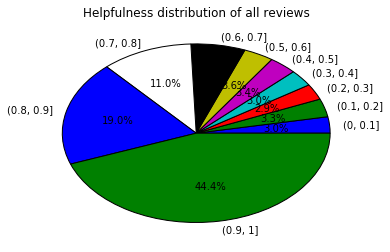

In [44]:
def plot_helpfulness_distribution(df):
    fig,ax = plt.subplots()
    helpful_cut = pd.cut(df['helpfulness'],
                         np.arange(0.0,1.1,0.1)).value_counts(sort=False)
    print(helpful_cut)
    ax.pie(helpful_cut,labels=helpful_cut.index, autopct='%1.1f%%')
    ax.set_title('Helpfulness distribution of all reviews')
plot_helpfulness_distribution(total_df)

We find that 44.4% of reviews fall in range(0.9,1] and 19% of reviews fall in range (0.8,0.9], which means that most of people believe that other people's review (with 10 votes or more) are helpful.

We then want to see the distribution of our input features.

In [27]:
def plot_feature_distribution(df,cut_range,feature_name):
    review_len_cut = pd.cut(df[feature_name],cut_range).value_counts(sort=False)
    ax = review_len_cut.plot.bar(logy=True)
    ax.set_title(feature_name +' distribution of all reviews')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('number of review')

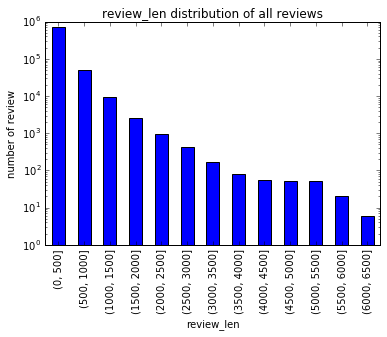

In [28]:
plot_feature_distribution(total_df,np.arange(0,7000,500),'review_len')

This figure shows the distribution of review length, which means that people tend to write short review, and the review length experiences an exponential decay every 500 increase in length.

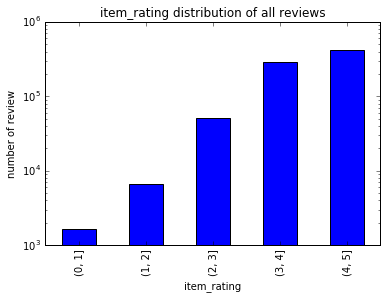

In [29]:
plot_feature_distribution(total_df,np.arange(0,6,1),'item_rating')

This figures show the distribution of item rating, which means people tend to give high score (3~5) to product.

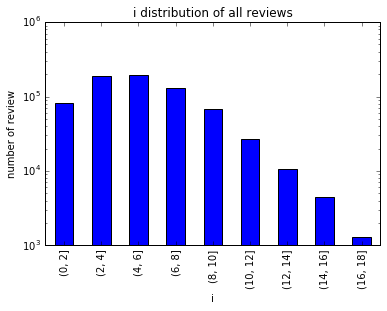

In [37]:
plot_feature_distribution(total_df,np.arange(0,20,2),'i')

Now let's look at an derived feature. This figure shows that number of 'I' presented in the review text, and it indicates that a review might mostly contain 0~10 times.

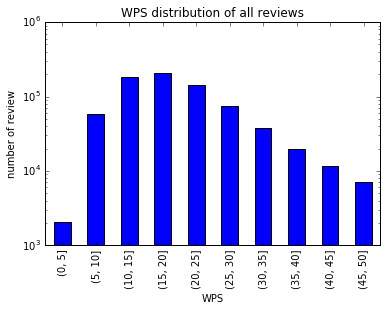

In [43]:
plot_feature_distribution(total_df,np.arange(0,55,5),'WPS')

'WPS' is also another derived feature which means word per sentence. A normal review will mostly contain 10~30 words per sentence.

## A glimpse of relationship between feature and output
We have already seen the distribution of some features, but what are the relationship between those features and our output, helpfulness? Apparently we should obtain this model through machine learning methods. But at least we could first look through plots and have an intuitive understanding of those relationships.

In [56]:
def plot_feature_helpfulness_relation(df,feature):
    a = df.groupby(feature).mean()
    b = a.iloc[:2000].copy()
    ax = b.plot(b.index, 'helpfulness', kind='line')
    ax.set_xlabel(feature)
    ax.set_ylabel('helpfulness')
    ax.set_title("relationship between helpfulness and "+feature)

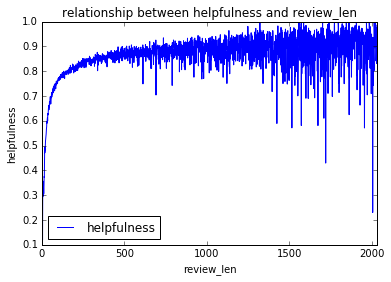

In [57]:
plot_feature_helpfulness_relation(total_df,'review_len')

Through this plot, we see that when review length is short, namely when review length is shorter than 500, there is an monotonic relationship between review length and helpfulness. As review length get larger, the relationship becomes not stable, thus meaning helpfulness can not solely depend on review length.

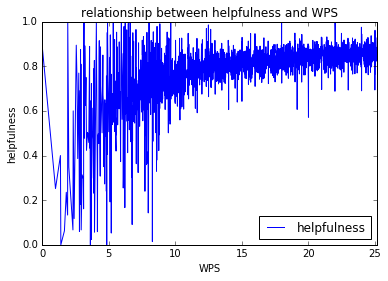

In [58]:
plot_feature_helpfulness_relation(total_df,'WPS')

We plot another figure for 'WPS' feature (word per sentence). We find that when word per sentence is lower than 10, helpfulness of review tends to be random. When wore per sentence gets larger, even though helpfulness is still not that stable, at least it is now restricted to a certain small range. 

These two figures tell us that our features can tell some differences between high-rating rivew and low-rating review. But how can we evaluate the relative improtance of each feature? Thus we use random forest to show feature importances of each feature in sklearn.py.

## Wordcloud of review text 
Finally let's look at wordcloud of review text in different categories to see which words are mostly used by reviewers.

In [5]:
from wordcloud import WordCloud

In [4]:
beauty.columns

Index(['Source (A)', 'Source (B)', 'Source (C)', 'Source (D)', 'Source (E)',
       'Source (F)', 'Source (G)', 'Source (H)', 'Source (I)', 'Source (J)',
       ...
       'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote',
       'Apostro', 'Parenth', 'OtherP'],
      dtype='object', length=106)

In [13]:
def plot_wordcloud_cat(category_df):
    raw_review = category_df['Source (H)']
    raw_review_str = raw_review.str.cat(sep=',')
    wc1 = WordCloud()
    wc1.generate(str(raw_review_str))
    plt.imshow(wc1, aspect='auto')

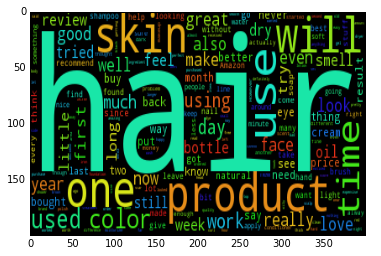

In [14]:
plot_wordcloud_cat(beauty)

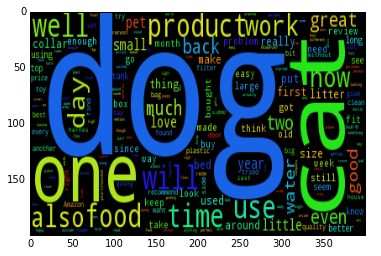

In [15]:
plot_wordcloud_cat(pet)

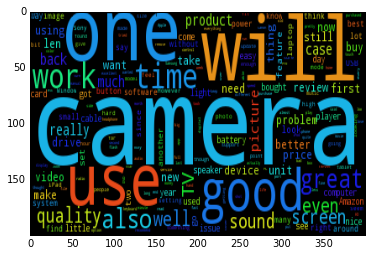

In [16]:
plot_wordcloud_cat(electronics)

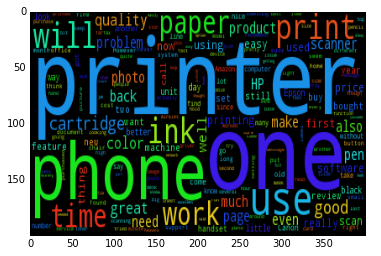

In [17]:
plot_wordcloud_cat(office)

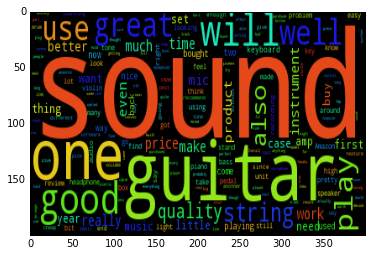

In [18]:
plot_wordcloud_cat(music)

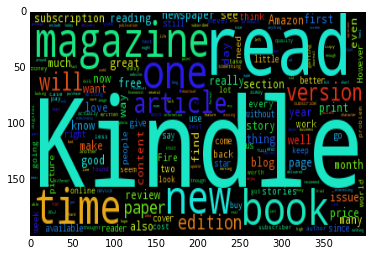

In [20]:
plot_wordcloud_cat(kindle)

We could see that the wordcloud of each categorical review is correspond to our intuition, for example, 'hair' and 'skin' in beauty, 'guitar' and 'sound' in music. 

This result conveys information that the linguistic composition of review in different category might be different. Since we are also using linguistic features in our machine learning step, we 'd better do regression or classification using one category per experiment.